In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import pickle

In [4]:
df = pd.read_csv("data/bank.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [6]:
print(df.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')


In [7]:
# Encode target variable
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df_encoded.drop('deposit', axis=1)
y = df_encoded['deposit']

In [8]:
y.value_counts()

deposit
0    5873
1    5289
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)

Training samples: (8929, 42)
Testing samples: (2233, 42)


In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

0
0


Model Training

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, random_state=42
    ),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

Model Evaluation Function

In [13]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef
)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "MCC": matthews_corrcoef(y_test, y_pred)
    }

Training and Evaluating Models

In [14]:
results = {}

for name, model in models.items():
    if name in ["Logistic Regression", "KNN"]:
        model.fit(X_train_scaled, y_train)
        results[name] = evaluate_model(
            model, X_test_scaled, y_test
        )
    else:
        model.fit(X_train, y_train)
        results[name] = evaluate_model(
            model, X_test, y_test
        )

/Users/MahathiSrikari/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:15:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [15]:
results_df = pd.DataFrame(results).T
results_df

,Accuracy,AUC,Precision,Recall,F1 Score,MCC
Logistic Regression,0.825795,0.907194,0.826979,0.799622,0.813071,0.650377
Decision Tree,0.797134,0.796222,0.790029,0.778828,0.784388,0.592917
KNN,0.778325,0.841606,0.799787,0.709830,0.752128,0.556148
Naive Bayes,0.733094,0.822651,0.799223,0.583176,0.674317,0.473757
Random Forest,0.857143,0.918669,0.826702,0.883743,0.854271,0.716010
XGBoost,0.864308,0.925727,0.841012,0.879962,0.860046,0.729198


Confusion Matrix

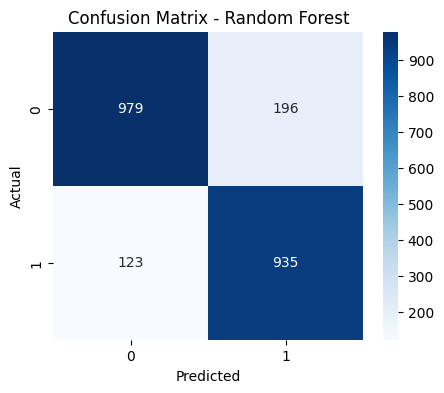

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Choose model
model_cm = models["Random Forest"]

# Predict
y_pred = model_cm.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [18]:
print("Classification Report - Random Forest\n")
print(classification_report(y_test, y_pred))

Classification Report - Random Forest

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1175
           1       0.83      0.88      0.85      1058

    accuracy                           0.86      2233
   macro avg       0.86      0.86      0.86      2233
weighted avg       0.86      0.86      0.86      2233



In [19]:
import os

os.makedirs("model", exist_ok=True)

Saving Trained Models

In [20]:
import pickle

for name, model in models.items():
    filename = name.lower().replace(" ", "_") + ".pkl"
    with open(f"model/{filename}", "wb") as f:
        pickle.dump(model, f)

print("All models saved successfully.")

All models saved successfully.


In [21]:
with open("model/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved successfully.")

Scaler saved successfully.


In [22]:
test_model = pickle.load(open("model/random_forest.pkl", "rb"))
test_pred = test_model.predict(X_test)
print("Model load test successful")

Model load test successful
